## Lesson-07 Recurrent Neural Networks 循环神经网络的原理及应用

循环神经网络是我们常用的一个网络模型，这个网络能够处理例如字符串，时间序列等问题。因为模型对序列问题的优势，RNN模型已经成为了自然语言处理问题的常见方法。

在本课程的作业中，我们将完成三个任务：

0. 基于任务驱动，实际感受并能够初步使用pytorch；
1. 使用RNN模型进行名字的国籍分类；(这个程序主要是参考的Pytorch文档)

RNN也可以用于金融数据的预测，例如:
![image.png](attachment:image.png)

![image.png](attachment:image.png)

上图中蓝色的部分就是预测值， 关于RNN模型对金融数据的预测，我们只会会增加专门的研讨课程，给大家讲解

我们今天带给大家的是使用RNN进行名字的国籍分类:

## 1. 使用RNN模型进行名字的国籍分类

首先，我们下载数据: 将这个数据置于和我们jupyter notebook位置相同的地方

#### 1.1 我们利用通配符，打印出所有的文件


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab Notebooks/Lesson7\ RNN

/content/drive/My Drive/Colab Notebooks/Lesson7 RNN


In [3]:
from io import open
import glob
import os
import matplotlib.pyplot as plt


def find_files(path): return glob.glob(path)

print(find_files('data/names/*.txt'))

['data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/German.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Russian.txt', 'data/names/Vietnamese.txt', 'data/names/Spanish.txt']


### 1.2 名字里边包含不少非Ascii码，为了简便问题，我们将他们转化为Ascii码

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_2_Ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

print(unicode_2_Ascii('Ślusàrski'))

Slusarski


### Step1.3 然后我们建立类别和对于的名字的dictionary对应

In [0]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_2_Ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [6]:
n_categories

18

In [7]:
category_lines['Chinese'][:10]

['Ang', 'AuYong', 'Bai', 'Ban', 'Bao', 'Bei', 'Bian', 'Bui', 'Cai', 'Cao']

### 1.4 这一次我们使用pytorch, 来进行向量化

In [8]:
import torch
print(torch.cuda.is_available())


False


In [9]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_index('J'))
print(letter_to_tensor('J').size())

print(line_to_tensor('Jones').size())

35
torch.Size([1, 57])
torch.Size([5, 1, 57])


In [10]:
line_to_tensor('Jones')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

我们可以看到，是对名字里的每个字符做了 one-hot操作

### 1.5 然后，我们构建一个这样的RNN网络

![image.png](attachment:image.png)

In [0]:
import torch.nn as nn

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [19]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(rnn)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)


### 1.6 运行一步RNN

为了运行这个rnn网络，我们需要给他一个input，然后再加上一个hidden state. 然后我们就能过获得一个output，这个output便是的是这个单词的属于每个国家的概率，和接下来的hidden state.

In [0]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [0]:
output

tensor([[-2.8389, -2.8629, -2.8731, -2.8508, -2.9721, -2.9985, -2.9089, -2.8004,
         -2.8253, -3.0009, -2.8182, -3.0161, -2.9267, -2.8319, -2.7858, -2.9676,
         -2.8417, -2.9554]], grad_fn=<LogSoftmaxBackward>)

In [0]:
next_hidden

tensor([[-0.0086, -0.0886, -0.0753, -0.0103, -0.0396, -0.0744,  0.0097, -0.0090,
          0.0736, -0.1183, -0.1131,  0.0222, -0.0096,  0.0106, -0.0413, -0.0354,
          0.0106, -0.0515, -0.1266, -0.1287, -0.1155, -0.0528,  0.0716, -0.0289,
          0.0355, -0.1315, -0.0308, -0.0499, -0.0395, -0.1189, -0.0247,  0.0986,
         -0.0618, -0.0666,  0.0429,  0.0013, -0.0295, -0.0358, -0.0402, -0.0136,
          0.0456,  0.0366,  0.0216,  0.0326,  0.0335,  0.0589,  0.0344,  0.0747,
          0.0767, -0.0037, -0.0867,  0.0363,  0.0571, -0.0245, -0.0264, -0.0353,
          0.0437, -0.0592,  0.0529, -0.0798, -0.0061,  0.0162, -0.0695,  0.0613,
          0.0611, -0.0749, -0.0742,  0.0069, -0.0748, -0.0468,  0.0847,  0.0073,
         -0.0576, -0.0955,  0.0984,  0.0631,  0.0710, -0.0253,  0.0951, -0.0064,
         -0.0354,  0.0043, -0.0488, -0.0247, -0.1007,  0.0215,  0.0114,  0.1316,
         -0.0232, -0.0312, -0.0535,  0.0913,  0.0284, -0.0715,  0.0405, -0.0767,
          0.0219, -0.0446, -

然后，我们可以使用 line_to_tensor, 把一句话直接变成 tensor

In [0]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8389, -2.8629, -2.8731, -2.8508, -2.9721, -2.9985, -2.9089, -2.8004,
         -2.8253, -3.0009, -2.8182, -3.0161, -2.9267, -2.8319, -2.7858, -2.9676,
         -2.8417, -2.9554]], grad_fn=<LogSoftmaxBackward>)


这个output，就是基于目前的RNN参数，预测出来的国籍概率分布。显然是不对的，因为里边的参数都是随机的。

### 1.7 更好的观察结果

为了能够更好的看到我们的训练结果，我们需要把输出的tensor变成我们能看懂的国籍

In [0]:
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i



对于刚刚产生的output，我们使用这个函数

In [0]:
print(category_from_output(output))

('Russian', 15)


### 1.8 随机生成训练数据

In [14]:
import random

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning():
    category = sample(all_categories)
    line = sample(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = sample_trainning()
    print('category =', category, '/ line =', line)

category = Korean / line = Ku
category = Polish / line = Wojewodka
category = Spanish / line = Rodriguez
category = Polish / line = Bukowski
category = Vietnamese / line = Nghiem
category = Czech / line = Oesterreicher
category = Japanese / line = Ieyasu
category = Czech / line = Kucharova
category = Arabic / line = Kalb
category = Polish / line = Gwozdek


### 因为我们这个模型需要 softmax 来获得每个类别，所以我们使用cross-entropy作为Loss函数


In [0]:
import time
import math

In [0]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
crossEntropyLoss = nn.CrossEntropyLoss()

In [0]:
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = crossEntropyLoss(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 500
plot_every = 100


# Keep track of losses for plotting
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = sample_trainning()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 0s) 2.9144 Ukiyo / Italian ✗ (Japanese)
1000 0% (0m 1s) 2.8353 Tadhgan / Scottish ✗ (Irish)
1500 0% (0m 2s) 2.8982 Sokolof / Russian ✗ (Polish)
2000 0% (0m 2s) 2.8992 Winther / Dutch ✗ (German)
2500 0% (0m 3s) 2.8925 Assaf / Russian ✗ (Arabic)
3000 0% (0m 4s) 2.8636 Sault / Portuguese ✗ (French)
3500 0% (0m 4s) 2.7621 Quintana / Japanese ✗ (Spanish)
4000 0% (0m 5s) 2.2779 Spini / Italian ✓
4500 0% (0m 6s) 2.6644 Rossum / Polish ✗ (Dutch)
5000 1% (0m 7s) 2.7509 Nuremberg / Greek ✗ (German)
5500 1% (0m 7s) 2.1114 Kahler / German ✓
6000 1% (0m 8s) 3.1503 Collins / Greek ✗ (Irish)
6500 1% (0m 9s) 2.7822 Searle / French ✗ (English)
7000 1% (0m 9s) 1.1003 Chin / Korean ✓
7500 1% (0m 10s) 3.0255 Morcos / Greek ✗ (Arabic)
8000 1% (0m 11s) 1.6496 Atarskikh / Russian ✓
8500 1% (0m 11s) 0.8092 Porshenkov / Russian ✓
9000 1% (0m 12s) 1.2350 Than / Chinese ✗ (Vietnamese)
9500 1% (0m 13s) 1.8809 Dubhan / Arabic ✗ (Irish)
10000 2% (0m 14s) 2.2613 Sitko / Portuguese ✗ (Polish)
10500 2% (0m 

### 1.9 观察Loss的变化

In [0]:
all_losses

[2.893020851612091,
 2.885711534023285,
 2.8887932682037354,
 2.8893515825271607,
 2.877090346813202,
 2.87438458442688,
 2.8583580613136292,
 2.8673184275627137,
 2.8608473682403566,
 2.849855806827545,
 2.8439738965034485,
 2.8374373388290404,
 2.845852987766266,
 2.8106672286987306,
 2.8169721961021423,
 2.799259052276611,
 2.8215492510795595,
 2.831789095401764,
 2.817036283016205,
 2.8061700224876405,
 2.806397967338562,
 2.824799613952637,
 2.7783629870414734,
 2.764262239933014,
 2.797190203666687,
 2.7818000984191893,
 2.8040004205703735,
 2.7643832397460937,
 2.7661886191368104,
 2.766247317790985,
 2.77183235168457,
 2.743371772766113,
 2.765405144691467,
 2.72670697927475,
 2.7144758439064027,
 2.722236535549164,
 2.7445504665374756,
 2.69373211145401,
 2.737808780670166,
 2.6848680663108824,
 2.667749718427658,
 2.6687712275981905,
 2.653934440612793,
 2.633327167034149,
 2.6271505439281464,
 2.599603865146637,
 2.5891010785102844,
 2.6092802131175996,
 2.56917640209198,
 2

In [0]:
%matplotlib inline

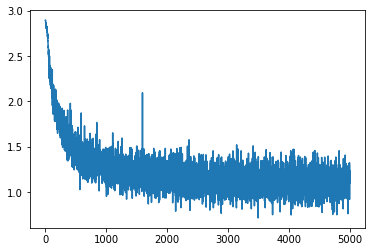

In [0]:
plt.plot(all_losses)

In [20]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Liu')
predict('Sun')
predict('Tian')


> Dovesky
(-2.76) Russian
(-2.79) Korean
(-2.80) French

> Jackson
(-2.78) Korean
(-2.79) Dutch
(-2.82) English

> Satoshi
(-2.79) Arabic
(-2.79) Dutch
(-2.80) French

> Liu
(-2.78) Arabic
(-2.79) French
(-2.81) Scottish

> Sun
(-2.77) Dutch
(-2.78) Korean
(-2.80) French

> Tian
(-2.75) Korean
(-2.77) Dutch
(-2.82) Japanese


## 代码练习

在构建模型之前先定义训练和评估的方法：

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cpu


In [0]:
import numpy as np

In [23]:
# Find letter index from all_letters, e.g. "a" = 0 
def letter_to_index(letter):
    return all_letters.find(letter)

# 将一个词转成tensor，shape（1，词的字母数， 字母数（n_letters））
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

# 将多个词转成tensor，shape（词数，最长词的字母数， 字母数（n_letters））
def lines_to_tensor(lines):
    tensor = torch.zeros(len(lines[0]), len(lines), n_letters)
    for i, line in enumerate(lines):
        for li, letter in enumerate(line):
            tensor[li][i][letter_to_index(letter)] = 1
    return tensor

def sample(l):
    return l[random.randint(0, len(l) - 1)]

def sample_trainning(n_batch):
    categories = [sample(all_categories) for i in range(n_batch)]
    lines = [sample(category_lines[category]) for category in categories]
    max_lines_count = np.max([len(item) for item in lines])
    lines = [' '*(max_lines_count - len(line)) + line for line in lines]
    
    categories_tensor = torch.tensor([all_categories.index(category) for category in categories], dtype=torch.long)
    lines_tensor = lines_to_tensor(lines)
    return categories, lines, categories_tensor, lines_tensor

for i in range(10):
    categories, lines, categories_tensor, lines_tensor = sample_trainning(4)
    print('categories =', categories, '/ lines =', lines)    

categories = ['Dutch', 'Dutch', 'English', 'English'] / lines = ['Schenck', ' Daalen', '  Brady', 'Travill']
categories = ['Czech', 'Portuguese', 'French', 'Vietnamese'] / lines = ['   Bleskan', '     Pinho', 'Sauveterre', '       Luc']
categories = ['Japanese', 'Vietnamese', 'German', 'Vietnamese'] / lines = ['   Sugita', '       Ha', 'Hellewege', '    Duong']
categories = ['Chinese', 'Japanese', 'Chinese', 'French'] / lines = ['    Jin', 'Obinata', '  Zhang', ' Baudin']
categories = ['Irish', 'Japanese', 'Portuguese', 'Polish'] / lines = ['Reynold', ' Honami', 'Pereira', '  Kijek']
categories = ['Portuguese', 'Spanish', 'Korean', 'Spanish'] / lines = ['    Silva', 'Sepulveda', '    Hyun ', ' Alvarado']
categories = ['Polish', 'Greek', 'Japanese', 'Spanish'] / lines = ['     Szwedko', '     Sortras', '     Okamura', 'De la fuente']
categories = ['Irish', 'Chinese', 'Portuguese', 'Greek'] / lines = ['Dubhan', '   Jiu', '  Cruz', ' Close']
categories = ['Japanese', 'Dutch', 'Vietnamese'

In [0]:
#训练方法
def _train_model(model, category_tensor, line_tensor, lossObj, device, optimizer, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        char_tensor = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = model(char_tensor, hidden)

    loss = lossObj(output.to(device), category_tensor.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

def categories_from_output(output):
    top_n, top_i = output.topk(1,dim=1)
    category_i_S = top_i.reshape(-1)
    return np.array([all_categories[category_i] for category_i in category_i_S]), category_i_S.cpu().data.numpy()

def train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch,
                  train_model_func = _train_model, 
                  lossObj = nn.CrossEntropyLoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
   
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    
    start = time.time()
    
    for iter in range(1, n_iters + 1):
        categories, lines, categories_tensor, lines_tensor = sample_trainning(n_batch)
        output, loss = train_model_func(model, categories_tensor, lines_tensor, lossObj, device, optimizer, n_batch)
        current_loss += loss
    
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categories_from_output(output)
            correct = '✓' if guess[0] == categories[0] else '✗ (%s)' % categories[0]
            correct_count = len([item for item in (guess == categories) if item == True])
            print('%d %d%% (%s) %.4f acc=%.4f %s / %s %s' % \
                  (iter, iter / n_iters * 100, time_since(start), loss, correct_count / n_batch, lines[0], guess[0], correct))
    
        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    
    return model, all_losses

In [0]:
# 评估方法
def evaluate(model, line_tensor, n_batch):
    hidden = model.initHidden(n_batch)

    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def predict(model, input_line, evaluate_func = evaluate, n_predictions=3):
    print('\n> %s' % input_line)
    model = model.cpu()

    model.eval()
    with torch.no_grad():
        output = evaluate_func(model, line_to_tensor(input_line), 1)

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

def get_train_acc(model, evaluate_func = evaluate):
    model.eval()
    all_correct_count = 0
    all_line_count = 0
    for category in all_categories:
        correct_count = 0
        for line in category_lines[category]:
            output = evaluate_func(model, line_to_tensor(line), 1)
            topv, topi = output.topk(1, 1)
            category_index = topi[0][0].item()
            if all_categories[category_index] == category :
                correct_count += 1
                all_correct_count += 1
        sub_all_line_count = len(category_lines[category])
        all_line_count += sub_all_line_count
        print('%s 总个数：%d, 正确个数: %d, acc: %.4f'\
              %(category, sub_all_line_count , correct_count, correct_count/sub_all_line_count))
    print('所有分类总个数：%d, 正确个数: %d, acc: %.4f'\
              %(all_line_count, all_correct_count, all_correct_count/all_line_count))
            
            

## 1. 尝试在我们的RNN模型中添加更多layers，然后观察Loss变化

> todo

In [0]:
class DepthRNN1(nn.Module):
    '''
    特点是： 增加循环层的数量，隐藏层中加入激活函数来增加隐藏层的表达能力，
    循环的末端的输出作为输出层的输入。
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(DepthRNN1, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.activation = nn.Tanh()
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        hidden = self.activation(self.i2h(combined))
        hidden = self.activation(self.h1(hidden))
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

In [0]:
class DepthRNN2(nn.Module):
    '''
    特点是： 增加循环层的数量，隐藏层中加入激活函数来增加隐藏层的表达能力，
    如老师给的案例一样，循环的输入合并后的输出作为输出层的输入。
    '''
    def __init__(self, input_size, hidden_size, output_size):
        super(DepthRNN2, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.activation = nn.Tanh()
        self.h1 = nn.Linear(hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        hidden = self.activation(self.i2h(combined))
        hidden = self.activation(self.h1(hidden))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

In [0]:
# 构建模型 DepthRNN1
n_hidden = 128
model = DepthRNN1(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("DepthRNN1_batch")

DepthRNN1(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (activation): Tanh()
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
2000 0% (0m 10s) 2.2962 acc=0.1250        Tojo / Vietnamese ✗ (Japanese)
4000 0% (0m 20s) 1.7011 acc=0.2500   Kappel / Czech ✗ (Dutch)
6000 1% (0m 31s) 1.8673 acc=0.2500    Moon / Chinese ✗ (Korean)
8000 1% (0m 43s) 1.5213 acc=0.5000        Hew / Korean ✗ (Chinese)
10000 2% (0m 53s) 1.5733 acc=0.5000    Seegers / Dutch ✓
12000 2% (1m 4s) 0.9194 acc=0.8750 Wojewodzki / Polish ✓
14000 2% (1m 15s) 1.8469 acc=0.5000      Abbey / Irish ✗ (English)
16000 3% (1m 25s) 1.4663 acc=0.5000  Nevins / English ✓
18000 3% (1m 35s) 2.7720 acc=0.0000 Duarte / French ✗ (Portuguese)
20000 4% (1m 46s) 1.5573 acc=0.5000      Dyerson / Scottish ✗ (English)
22000 4% (1m 56s) 2.0989 acc=0.1250            Acosta / Czech ✗ (Spanish)
24000 4% (2m 6s) 1.3945 acc=0.6250    

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DepthRNN1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


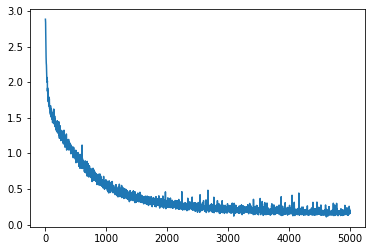

In [31]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 2000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "DepthRNN1_batch")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)

In [32]:
get_train_acc(model)

Italian 总个数：709, 正确个数: 675, acc: 0.9520
Irish 总个数：232, 正确个数: 223, acc: 0.9612
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 263, acc: 0.9495
Czech 总个数：519, 正确个数: 503, acc: 0.9692
Dutch 总个数：297, 正确个数: 288, acc: 0.9697
Greek 总个数：203, 正确个数: 202, acc: 0.9951
German 总个数：724, 正确个数: 664, acc: 0.9171
English 总个数：3668, 正确个数: 3109, acc: 0.8476
Chinese 总个数：268, 正确个数: 243, acc: 0.9067
Japanese 总个数：991, 正确个数: 980, acc: 0.9889
Korean 总个数：94, 正确个数: 86, acc: 0.9149
Polish 总个数：139, 正确个数: 133, acc: 0.9568
Portuguese 总个数：74, 正确个数: 73, acc: 0.9865
Scottish 总个数：100, 正确个数: 99, acc: 0.9900
Russian 总个数：9408, 正确个数: 8504, acc: 0.9039
Vietnamese 总个数：73, 正确个数: 71, acc: 0.9726
Spanish 总个数：298, 正确个数: 249, acc: 0.8356
所有分类总个数：20074, 正确个数: 18365, acc: 0.9149


In [0]:
# 构建模型 DepthRNN2
n_hidden = 128
model = DepthRNN2(n_letters, n_hidden, n_categories)

In [0]:
#model = torch.load("DepthRNN2_batch")

DepthRNN2(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (activation): Tanh()
  (h1): Linear(in_features=128, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 5s) 2.3480 acc=0.2500   Ashwell / French ✗ (English)
2000 0% (0m 10s) 2.6121 acc=0.1250      Braun / Arabic ✗ (German)
3000 0% (0m 15s) 2.0553 acc=0.6250  Bekrenev / Dutch ✗ (Russian)
4000 0% (0m 20s) 2.2354 acc=0.3750       Bassi / Arabic ✗ (Italian)
5000 1% (0m 25s) 2.2210 acc=0.6250    Smets / Dutch ✓
6000 1% (0m 30s) 1.9981 acc=0.2500    Torres / Dutch ✗ (Portuguese)
7000 1% (0m 35s) 2.5619 acc=0.2500   Nguyen / Vietnamese ✓
8000 1% (0m 40s) 2.0162 acc=0.1250 Ventura / Dutch ✗ (Spanish)
9000 1% (0m 45s) 1.9118 acc=0.3750     Mahoney / Arabic ✗ (Irish)
10000 2% (0m 50s) 2.1664 acc=0.2500        Kan / Chinese ✗ (Dutch)
11000 2% (0m 55s) 2.3733 acc=0.3750 Amatore / French ✗ (Italian)
12000 2% (1m 0s) 2.2465 acc=0.2500      Thake / 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DepthRNN2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


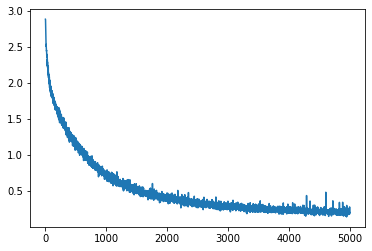

In [34]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "DepthRNN2_batch")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)

In [35]:
get_train_acc(model)

Italian 总个数：709, 正确个数: 667, acc: 0.9408
Irish 总个数：232, 正确个数: 225, acc: 0.9698
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 265, acc: 0.9567
Czech 总个数：519, 正确个数: 495, acc: 0.9538
Dutch 总个数：297, 正确个数: 291, acc: 0.9798
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 636, acc: 0.8785
English 总个数：3668, 正确个数: 2934, acc: 0.7999
Chinese 总个数：268, 正确个数: 232, acc: 0.8657
Japanese 总个数：991, 正确个数: 976, acc: 0.9849
Korean 总个数：94, 正确个数: 88, acc: 0.9362
Polish 总个数：139, 正确个数: 137, acc: 0.9856
Portuguese 总个数：74, 正确个数: 74, acc: 1.0000
Scottish 总个数：100, 正确个数: 98, acc: 0.9800
Russian 总个数：9408, 正确个数: 8440, acc: 0.8971
Vietnamese 总个数：73, 正确个数: 68, acc: 0.9315
Spanish 总个数：298, 正确个数: 253, acc: 0.8490
所有分类总个数：20074, 正确个数: 18082, acc: 0.9008


### 2. 将原始的RNN模型改成nn.LSTM和nn.GRU， 并且改变 `n_iters = 1000 ` 这个值，观察其变化

> todo

In [0]:
#训练方法
def lstm_train_model(model, category_tensor, line_tensor, lossObj, device, optimizer, n_batch):
    hidden = model.initHidden(n_batch)
    out = model.initOut(n_batch)
    hidden = hidden.to(device)
    out = out.to(device)
    
    for i in range(line_tensor.size()[0]):
        char_tensor = line_tensor[i].to(device)
        output, hidden, out = model(char_tensor, hidden, out)

    loss = lossObj(output.to(device), category_tensor.to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

# 评估方法
def lstm_evaluate(model, line_tensor, n_batch):
    hidden = model.initHidden(n_batch)
    out = model.initOut(n_batch)

    for i in range(line_tensor.size()[0]):
        output, hidden, out = model(line_tensor[i], hidden, out)

    return output

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.output_size = output_size
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.forgetDoor = nn.Linear(input_size + hidden_size, hidden_size)
        self.inputDoor = nn.Linear(input_size + hidden_size, hidden_size)
        self.inputMain = nn.Linear(input_size + hidden_size, hidden_size)
        self.outDoor = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor = None, out:torch.Tensor = None):
        # n_batch = input.shape[1]
        # my_device = input.device
        # hidden = (hidden if hidden != None else self.initHidden(n_batch)).to(my_device)
        # out = (out if out != None else self.initOut(n_batch)).to(my_device)
        combined = torch.cat((input, out), 1)
        forget_door = self.sigmoid(self.forgetDoor(combined))
        hidden = forget_door * hidden
        input_door = self.sigmoid(self.inputDoor(combined))
        input_main = self.tanh(self.inputDoor(combined))
        hidden += input_door * input_main
        out_door = self.sigmoid(self.outDoor(combined))
        out = out_door * self.tanh(hidden)
        output = self.softmax(self.i2o(out))
        
        return output, hidden, out

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    
    def initOut(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)
    

In [0]:
# 构建模型 LSTM
n_hidden = 128
model = LSTM(n_letters, n_hidden, n_categories)

In [0]:
model = torch.load("LSTM")

LSTM(
  (forgetDoor): Linear(in_features=185, out_features=128, bias=True)
  (inputDoor): Linear(in_features=185, out_features=128, bias=True)
  (inputMain): Linear(in_features=185, out_features=128, bias=True)
  (outDoor): Linear(in_features=185, out_features=128, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 9s) 2.9631 acc=0.0000 Filipowski / Greek ✗ (Polish)
2000 0% (0m 18s) 2.5651 acc=0.3750       Broz / Vietnamese ✗ (Polish)
3000 0% (0m 27s) 2.7695 acc=0.2500   Hirase / French ✗ (Japanese)
4000 0% (0m 36s) 2.5317 acc=0.0000 Leeuwenhoek / German ✗ (Dutch)
5000 1% (0m 45s) 2.7799 acc=0.1250      Castro / Portuguese ✓
6000 1% (0m 54s) 1.8916 acc=0.3750      Guan / Vietnamese ✗ (Chinese)
7000 1% (1m 3s) 1.8815 acc=0.5000 De santigo / Italian ✗ (Portuguese)
8000 1% (1m 12s) 2.0414 acc=0.2500  Neuman / Irish ✗ (German)
9000 1% (1m 21s) 1.9913 acc=0.3750     Altena / Spanish ✗ (Dutch

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


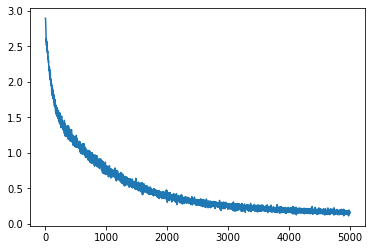

In [0]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch,
                                  train_model_func = lstm_train_model)
torch.save(model, "LSTM")
# 评估
print("评估")
predict(model, 'Dovesky', evaluate_func = lstm_evaluate)
predict(model, 'Jackson', evaluate_func = lstm_evaluate)
predict(model, 'Satoshi', evaluate_func = lstm_evaluate)
predict(model, 'Liu', evaluate_func = lstm_evaluate)
predict(model, 'Sun', evaluate_func = lstm_evaluate)
predict(model, 'Tian', evaluate_func = lstm_evaluate)
plt.plot(all_losses)

In [0]:
get_train_acc(model, evaluate_func = lstm_evaluate)

Italian 总个数：709, 正确个数: 669, acc: 0.9436
Irish 总个数：232, 正确个数: 224, acc: 0.9655
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 261, acc: 0.9422
Czech 总个数：519, 正确个数: 495, acc: 0.9538
Dutch 总个数：297, 正确个数: 280, acc: 0.9428
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 643, acc: 0.8881
English 总个数：3668, 正确个数: 2920, acc: 0.7961
Chinese 总个数：268, 正确个数: 234, acc: 0.8731
Japanese 总个数：991, 正确个数: 973, acc: 0.9818
Korean 总个数：94, 正确个数: 78, acc: 0.8298
Polish 总个数：139, 正确个数: 138, acc: 0.9928
Portuguese 总个数：74, 正确个数: 72, acc: 0.9730
Scottish 总个数：100, 正确个数: 100, acc: 1.0000
Russian 总个数：9408, 正确个数: 8647, acc: 0.9191
Vietnamese 总个数：73, 正确个数: 63, acc: 0.8630
Spanish 总个数：298, 正确个数: 248, acc: 0.8322
所有分类总个数：20074, 正确个数: 18248, acc: 0.9090


参考： https://www.cnblogs.com/jiangxinyang/p/9376021.html

![GRU Image](https://images2018.cnblogs.com/blog/1335117/201807/1335117-20180727095108158-462781335.png)

In [0]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.r_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.z_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.h_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input:torch.Tensor, hidden:torch.Tensor):
        combined = torch.cat((input, hidden), 1)
        r = self.sigmoid(self.r_gate(combined))
        z = self.sigmoid(self.z_gate(combined))
        combined2 = torch.cat((r * hidden, input), 1)
        h_hat = self.tanh(self.h_gate(combined2))
        hidden = (1-z) * hidden + z * h_hat
        output = self.softmax(self.i2o(hidden))
        return output, hidden

    def initHidden(self, n_batch):
        return torch.zeros(n_batch, self.hidden_size)

In [0]:
# 构建模型 DepthRNN1
n_hidden = 128
model = GRU(n_letters, n_hidden, n_categories)

In [0]:
model = torch.load("GRU")

GRU(
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (r_gate): Linear(in_features=185, out_features=128, bias=True)
  (z_gate): Linear(in_features=185, out_features=128, bias=True)
  (h_gate): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax()
)
1000 0% (0m 8s) 2.7069 acc=0.1250    Gorski / French ✗ (Polish)
2000 0% (0m 16s) 2.3473 acc=0.1250     Baba / Arabic ✗ (Japanese)
3000 0% (0m 25s) 2.4190 acc=0.2500             Roig / Arabic ✗ (Spanish)
4000 0% (0m 33s) 2.1311 acc=0.2500    Greig / German ✗ (English)
5000 1% (0m 42s) 2.4766 acc=0.3750     Crespo / Portuguese ✓
6000 1% (0m 50s) 1.7152 acc=0.3750 Kaminski / Polish ✓
7000 1% (0m 59s) 1.6717 acc=0.3750 Majewski / Polish ✓
8000 1% (1m 7s) 1.9696 acc=0.1250        Uhlik / Polish ✗ (Czech)
9000 1% (1m 16s) 1.3509 acc=0.6250         Oh  / Korean ✓
10000 2% (1m 24s) 1.2159 acc=0.3750  Lennox / Scottish ✗ (English)
11000 2% (1m 33s) 1.5347 acc=0.2500   Med

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


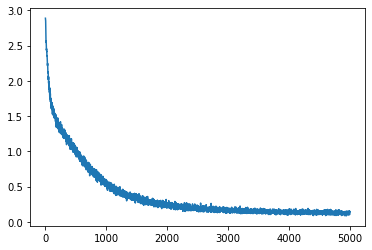

In [0]:
print(model)
model.train()
model = model.to(device)
# 超参数
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
n_iters = 500000 # 这个数字你可以调大一些
print_every = 1000
plot_every = 100
n_batch = 8
# 训练
model, all_losses = train_process(model, learning_rate, n_iters, print_every, plot_every, n_batch)
torch.save(model, "GRU")
# 评估
print("评估")
predict(model, 'Dovesky')
predict(model, 'Jackson')
predict(model, 'Satoshi')
predict(model, 'Liu')
predict(model, 'Sun')
predict(model, 'Tian')
plt.plot(all_losses)

In [0]:
get_train_acc(model)

Italian 总个数：709, 正确个数: 674, acc: 0.9506
Irish 总个数：232, 正确个数: 222, acc: 0.9569
Arabic 总个数：2000, 正确个数: 2000, acc: 1.0000
French 总个数：277, 正确个数: 264, acc: 0.9531
Czech 总个数：519, 正确个数: 501, acc: 0.9653
Dutch 总个数：297, 正确个数: 279, acc: 0.9394
Greek 总个数：203, 正确个数: 203, acc: 1.0000
German 总个数：724, 正确个数: 650, acc: 0.8978
English 总个数：3668, 正确个数: 3286, acc: 0.8959
Chinese 总个数：268, 正确个数: 247, acc: 0.9216
Japanese 总个数：991, 正确个数: 984, acc: 0.9929
Korean 总个数：94, 正确个数: 80, acc: 0.8511
Polish 总个数：139, 正确个数: 137, acc: 0.9856
Portuguese 总个数：74, 正确个数: 68, acc: 0.9189
Scottish 总个数：100, 正确个数: 97, acc: 0.9700
Russian 总个数：9408, 正确个数: 8967, acc: 0.9531
Vietnamese 总个数：73, 正确个数: 62, acc: 0.8493
Spanish 总个数：298, 正确个数: 248, acc: 0.8322
所有分类总个数：20074, 正确个数: 18969, acc: 0.9450


### 3. 把该RNN模型变成多层RNN模型，观察Loss的变化

> todo

### 4. Pytorch里边常用nn.NLLoss来代替crossentropy，将criterion改为nn.NLLoss，观察变化

> todo